In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
#Read Datasets and check if dataset has been read properly
ratings = pd.read_csv('ml-32m/ratings.csv')
movies = pd.read_csv('ml-32m/movies.csv')
print("Ratings Data")
print(ratings.head())
print("\nMovies Data")
print(movies.head())

Ratings Data
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Movies Data
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [3]:
#Display Dimensions of DataFrame
print(f"Ratings Dataset: {ratings.shape}")
print(f"Movies Dataset: {movies.shape}")

Ratings Dataset: (32000237, 4)
Movies Dataset: (87585, 3)


In [4]:
#Check for missing values in Ratings and Movies DataFrame
print("Missing Values in Ratings")
print(ratings.isnull().sum())
print("Missing Values in Movies")
print(movies.isnull().sum())

Missing Values in Ratings
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing Values in Movies
movieId    0
title      0
genres     0
dtype: int64


/var/folders/80/x4mqvsbs4t92fk9wgb844pl40000gn/T/ipykernel_39963/457146126.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x='rating', palette='viridis')


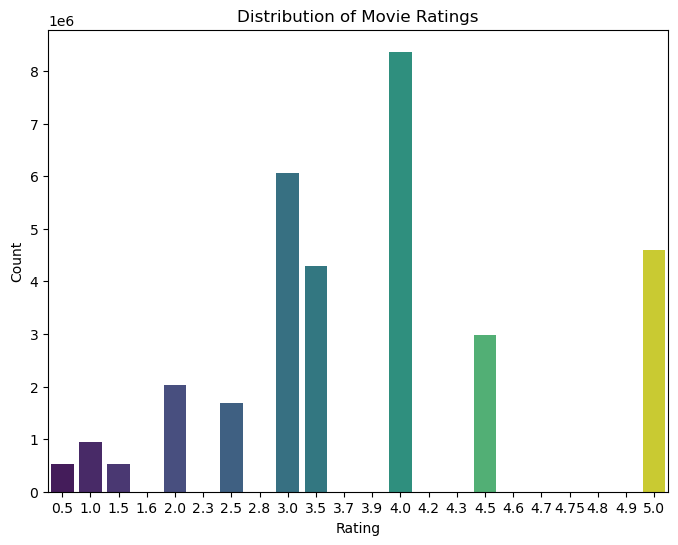

In [5]:
#Data Visualization to check distribution of ratings
plt.figure(figsize=(8,6))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [6]:
#Check Datatypes and make sure they're consistent (Data Cleaning)
print("Ratings Data Types: ")
print(ratings.dtypes)

print("\nMovies Data Types: ")
print(movies.dtypes)

ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)
movies['movieId'] = movies['movieId'].astype(int)

Ratings Data Types: 
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Movies Data Types: 
movieId     int64
title      object
genres     object
dtype: object


In [7]:
#Remove Duplicate Rows
duplicates=ratings.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

ratings = ratings.drop_duplicates()

Number of duplicate rows: 0


In [8]:
#Use Surprise to make recommedation system. Structure the data and set up the data in a way surprise can understand
#Import and Initialise SVD Algorithm from Surprise Library (if model does not exist) or load model if it does
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from joblib import dump, load
import os

model_path = 'svd_model.joblib'

if os.path.exists(model_path):
    algo=load(model_path)
    print("Loaded existing model from disk")
else:
    algo = SVD()
    reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
    
    #Use subset of data to evaluate overall performance of model using 3-fold cross-validation
    sample_size = int(0.01 * len(ratings))
    ratings_subset = ratings.sample(n = sample_size, random_state=42)
    
    data_subset = Dataset.load_from_df(ratings_subset[['userId', 'movieId', 'rating']], reader)

    #Use fulldata and training split to eventually train model

    data_surprise = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    
    #Evaluating the SVD Algorithm using 3-fold Cross Validation
    print("Evaluating the SVD Algorithm using 3-fold Cross Validation:")
    cross_validate(algo, data_subset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

    #Divide dataset into training set (80%) and test set (20%), train model and use RMSE and MAE to calculate error on predictions
    
    trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)
    algo.fit(trainset)
    predictions = algo.test(testset)

    dump(algo, model_path)
    print(f"Model trained and saved to {model_path}")
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    print(f"RMSE on Test Set: {rmse}")
    print(f"MAE on Test Set: {mae}")


Loaded existing model from disk


In [9]:
#Running an example prediction
user_id = 1
movie_id = 17
pred = algo.predict(user_id, movie_id)
#User 1 actually rated the movie with MovieId: 17 as 4.0. Model's predicted rating was 3.88
print(pred)

#Example2
user_id = 10
movie_id = 1693
pred = algo.predict(user_id, movie_id)
#User 10 actually rated the movie with MovieId: 1693 as 2.5. Model's predicted rating was 2.87
print(pred)

user: 1          item: 17         r_ui = None   est = 3.40   {'was_impossible': False}
user: 10         item: 1693       r_ui = None   est = 2.92   {'was_impossible': False}


In [10]:
#Building the actual recommendation system
def get_top_n_recommendations(algo, user_id, movies_df, ratings_df, n=10):
    """
    Generate top N movie recommendations for a user

    Parameters:
    - algo: Trained Surprise Algorithm
    - user_id: ID of the user
    - movies_df: Dataframe containing the movies data
    - ratings_df: Dataframe containing the ratings data
    - n: Number of recommendations to return

    """
    all_movie_ids = movies_df['movieId'].unique()
    
    rated_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

    unrated_movie_ids = [movie for movie in all_movie_ids if movie not in rated_movie_ids]

    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    
    predictions.sort(key = lambda x: x.est, reverse=True)
    
    top_n = predictions[:n]
    
    top_n_movies = [(movies_df[movies_df['movieId'] == int(pred.iid)]['title'].values[0], pred.est) for pred in top_n]
    return top_n_movies
    
    

In [11]:
#Printing top 10 recommendations for user
top_recommendations = get_top_n_recommendations(algo, user_id=1, movies_df = movies, ratings_df = ratings, n=10)
print("Top 10 Movie Recommendations for User1: ")

for title, rating in top_recommendations:
    print(f"{title}: {rating:.2f}")

Top 10 Movie Recommendations for User1: 
Alien (1979): 5.00
Mad Max: Fury Road (2015): 4.62
McCabe & Mrs. Miller (1971): 4.61
Mulholland Drive (2001): 4.61
Beauty and the Beast (La belle et la bête) (1946): 4.61
Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972): 4.60
Night of the Living Dead (1968): 4.59
Haunting, The (1963): 4.58
Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999): 4.57
Seven Samurai (Shichinin no samurai) (1954): 4.55


In [12]:
# #Grid Search to find optimal parameters to further improve model
# from surprise.model_selection import GridSearchCV

# param_grid = {
#     'n_factors': [50, 75, 100, 125, 150],
#     'n_epochs': [20, 30, 40],
#     'lr_all': [0.002, 0.005, 0.01],
#     'reg_all': [0.02, 0.05, 0.1]
# }


# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=3)

# print("Starting Grid Search on 1% of dataset to find optimal SVD hyperparameters: ")

# sample_size = int(0.1 * len(ratings))
# ratings_subset = ratings.sample(n = sample_size, random_state=42)
# reader = Reader(rating_scale=(ratings_subset['rating'].min(), ratings_subset['rating'].max()))
# data_subset = Dataset.load_from_df(ratings_subset[['userId', 'movieId', 'rating']], reader)

# gs.fit(data_subset)

# print("Grid Search Complete")

# print(f"Best Parameters for SVD based on RMSE: {gs.best_params['rmse']}")

# print(f"Best RMSE Score: {gs.best_score['rmse']}")

# print(f"gs: {gs}")

# print(f"Best Parameters for SVD based on MAE: {gs.best_params['mae']}")

# print(f"Best MAE Score: {gs.best_score['mae']}")



In [23]:
#Work on combining current model with Content Based Filtering
#Load our model and read csvs
import pandas as pd
from joblib import load

movies = pd.read_csv('ml-32m/movies.csv')
ratings = pd.read_csv('ml-32m/ratings.csv')
# subset_size = 10000
# movies = movies.head(subset_size)

#Combine title and genres into one text field for each movie
movies['combined_features'] = movies['title'] + movies['genres']

In [24]:
algo = load('svd_model.joblib')

In [25]:
#Initialize TF-IDF Vectorizer and compute TF-IDF matrix for the combined features of movies
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

print(tfidf_matrix.shape) 

(87585, 42994)


In [26]:
#Compute cosine similarity matrix for all movies based on TF-IDF Vectors
# from sklearn.metrics.pairwise import linear_kernel

# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# print(cosine_sim.shape)

#Cosine Similarity will not work as the dataset is too massive which causes the kernel to crash. Dataset is too big. Cosine Similarity is impractical

In [27]:
#Using Annoy instead of Cosine Similarity Matrix to get approximate nearest neighbours
from annoy import AnnoyIndex
import os

#Get number of features from our TF-IDF Matrix
num_features = tfidf_matrix.shape[1]
index = AnnoyIndex(num_features, 'angular')

%load_ext memory_profiler
#Add each movie's TF-IDF Vector to the Annoy Index
if os.path.exists('annoy_index.ann'):
    index.load('annoy_index.ann')
    print(f"Loaded Annoy Index")
else:
    print(f"Number of movies: {tfidf_matrix.shape[0]}")
    num_movies = 67000
    print(f"Number of movies being added right now: {num_movies}")
    %memit
    for i in range(num_movies):
        #Convert sparse row to array that can be used as vector for index
        vector = tfidf_matrix.getrow(i).astype('float32').toarray()[0]
        index.add_item(i,vector)
        if (i+1) % 10000 == 0:
            print(f"Added {i+1} movies to the Annoy Index")
    
    #Build index with chosen number of trees 
    num_tree = 12
    print(f"Building Annoy Index with {num_tree} trees. This may take a while...")
    index.build(num_tree)
    print("Annoy Index Built Successfully")
    
    #Saving Index to Disk to avoid rebuilding over and over again
    annoy_index_filename = 'annoy_index.ann'
    index.save(annoy_index_filename)
    print(f"Annoy Index with {num_movies} movies saved to {annoy_index_filename}")
    

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Loaded Annoy Index


In [31]:
#Same function as above for Collaborative Filtering. Returning the movies it recommends and their respective ratings
def get_top_n_cf_recommendations(algo, user_id, movies_df, ratings_df, n=10):
    """
    Generate top N movie recommendations for a user

    Parameters:
    - algo: Trained Surprise Algorithm
    - user_id: ID of the user
    - movies_df: Dataframe containing the movies data
    - ratings_df: Dataframe containing the ratings data
    - n: Number of recommendations to return

    """
    all_movie_ids = movies_df['movieId'].unique()
    
    rated_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

    unrated_movie_ids = [movie for movie in all_movie_ids if movie not in rated_movie_ids]

    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    
    predictions.sort(key = lambda x: x.est, reverse=True)
    
    top_n = predictions[:n]

    final_top10_pred = []
    for pred in top_n:
        final_top10_pred.append((pred.iid, pred.est))

    #print(f"Top 20 movies recommended by Collaborative Model are: {final_top10_pred}")
    
    return final_top10_pred

In [32]:
# #Get Top 10 Content based recommendations based on cosine similarity matrix (will not work as cosine similarity matrix is impractical)
# def get_content_based_recommendations(movie_id, movies_df, cosine_sim, top_n=10):
    
#     #Retrieve index of the movie we are getting recommendations for based on movieId
#     idx = movies_df.index[movies_df['movieId'] == movie_id].tolist()[0]

#     #remove this line
#     print(movies_df.index[movies_df['movieId'] == movie_id].tolist())

#     #Get a list of tuples of the form: (movie_index, similarity_score)
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     #Sort movies based on similarity score
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     #Exclude the movie itself and top_n similar movies
#     sim_scores = sim_scores[1:top_n+1]

#     #Get the movie indices for these scores
#     movie_indices = [i[0] for i in sim_scores]

#     #Return movies corresponding to these indices
#     return movies_df.iloc[movie_indices][['movieId','title','genres']]

def get_content_based_recommendations(movie_id, movies_df, index, top_n=10, num_movies=67000):
    # neighbours = index.get_nns_by_item(0, 10)
    # print("Nearest neighbors for movie 0:", neighbors)
    #return neighbours
    idx = movies_df.index[movies_df['movieId'] == movie_id].tolist()[0]
    similar_indices = []
    if idx <= num_movies:
        similar_indices = index.get_nns_by_item(idx, top_n)
    else:
        similar_indices = [idx]
    #similar_indices = [i for i in similar_indices if i != idx]
    similar_movies = movies_df.iloc[similar_indices][['movieId', 'title', 'genres']]
    return similar_movies
    
    
    



In [36]:
def hybrid_recommendations(algo, user_id, movies_df, ratings_df, index, top_n_cf=10, top_n_cb=10, num_movies=67000):
    # Generate Hybrid Recommendations using both our collaborative filtering model and content based methods
    cf_recs = get_top_n_cf_recommendations(algo, user_id, movies_df, ratings_df, n = top_n_cf)

    combined_recs = {}

    for movie_id, predicted_rating in cf_recs:
        print(f"movie id being searched right now: {movie_id}")
        similar_movies = get_content_based_recommendations(movie_id, movies_df, index, top_n=top_n_cb, num_movies=num_movies)
        print(f"rows: {similar_movies.shape[0]}")
        for _, row in similar_movies.iterrows():
            sim_movie_id = row['movieId']
            title = row['title']
            if sim_movie_id not in combined_recs:
                combined_recs[sim_movie_id] = {'title':title, 'count': 1}
            else:
                combined_recs[sim_movie_id]['count'] += 1

    recs_list = [{'movieId': mid, 'title': info['title'], 'score': info['count']} for mid, info in combined_recs.items()]

    recs_df = pd.DataFrame(recs_list)
    recs_df = recs_df.sort_values(by='score', ascending=False).head(10)

    return recs_df
    

user_id = 200949
hybrid_recs = hybrid_recommendations(algo, user_id, movies, ratings, index, 10, 10, 67000)
print(f"Hybrid Recommendations for User: {user_id}")
print(hybrid_recs)
    

movie id being searched right now: 171331
rows: 10
movie id being searched right now: 228099
rows: 1
movie id being searched right now: 179135
rows: 10
movie id being searched right now: 171011
rows: 10
movie id being searched right now: 252710
rows: 1
movie id being searched right now: 33166
rows: 10
movie id being searched right now: 167832
rows: 10
movie id being searched right now: 318
rows: 10
movie id being searched right now: 171749
rows: 10
movie id being searched right now: 171187
rows: 10
Hybrid Recommendations for User: 200949
    movieId                              title  score
11   179135              Blue Planet II (2017)      2
17   161181          A Beautiful Planet (2016)      2
16    95294                Planet B-Boy (2007)      2
15   211864                  The Planet (2006)      2
13   171011             Planet Earth II (2016)      2
52    99735          Road to Redemption (2001)      1
57   171749  Death Note: Desu nôto (2006–2007)      1
56    81520  Undisputed 